##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Score predictions of fitted model.
def score_algo(model, X, y, prediction, validation_score, show_ratio=True):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('R^2:', round(r2_score(y, prediction), 4))
    mae = round(mean_absolute_error(y, prediction),2)
    print('MAE:', mae)
    if show_ratio == True:
        print('Ratio to Valid Score:', round(mae/validation_score,3))

In [3]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

In [4]:
#Read in data tables.  Put quotes around table to make case-sensitive.
vehicle=pd.read_sql('SELECT * from vehicle', engine, index_col='index')
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
vehicle.index.name=None; train.index.name=None; test.index.name=None;

##  Nonlinear Models - LightGBM

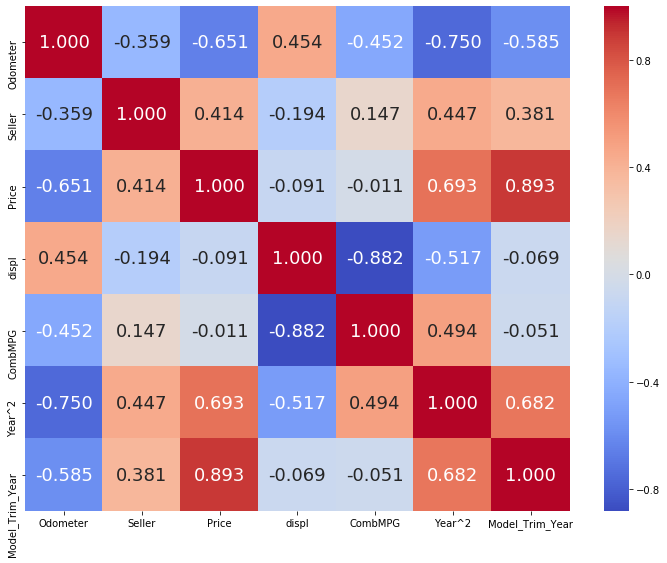

In [5]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

<a id='section_id1'></a>

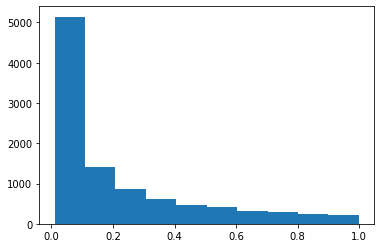

In [6]:
#Log uniform distribution from scikit-optimize
plt.hist(Real(0.01, 1.0, 'log-uniform').rvs(n_samples=10000))
plt.show()

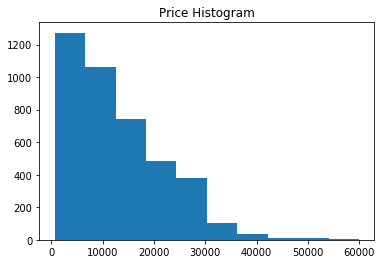

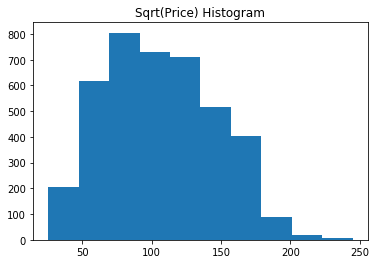

'X features:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
17767,53887.0,15621.337884,3.5,19.0,4068289.0,29460.542126
15496,24469.0,15621.337884,2.0,29.5,4072324.0,10417.875507


In [7]:
#Split out Price.
trainX = train.copy()
trainY = trainX.pop('Price')
plt.hist(trainY); plt.title('Price Histogram'); plt.show();
testX = test.copy()
testY = testX.pop('Price')

#Normalize Price
trainY = np.sqrt(trainY)
testY = np.sqrt(testY)
plt.hist(trainY); plt.title('Sqrt(Price) Histogram'); plt.show();
display('X features:', trainX.head(2))

### LightGBM model

In [8]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=5, n_jobs=-1, refit=True,\
                           scoring='neg_mean_absolute_error', return_train_score=False,random_state=40)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trainX, trainY)

#Tuned model best score.
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
mean_score = np.round(lgb_model.cv_results_["mean_test_score"],2)
print(f'## mean valid scores: {mean_score})', '\n')
print(f'## best valid score: {-lgb_model.best_score_:.2f} +- {best_score_std:.2f}','\n')   
print('## Best parameters:')
pprint.pprint(lgb_model.best_params_)
print('\n')
      
#SCORE model on full data (thanks to refit).
y_test_pred = lgb_model.predict(testX)
print('Sqrt(Price):')
score_algo(lgb_model, testX, testY, y_test_pred, -lgb_model.best_score_)
print('\nPrice:')
score_algo(lgb_model, testX, testY**2, y_test_pred**2, lgb_model.best_score_, show_ratio=False) 

#Get feature importances using eli5.
perm = PermutationImportance(lgb_model, n_iter=20).fit(testX, testY)
display(eli5.show_weights(perm, feature_names = testX.columns.tolist()))

## Grid iters checked: 30 

## mean valid scores: [ -9.97  -9.81  -9.65 -10.59  -9.79 -10.66 -11.26  -9.92  -9.8  -14.49
 -11.27  -9.71 -10.02 -17.28  -9.72 -10.46  -9.76  -9.79  -9.82  -9.72
  -9.76  -9.7  -11.82 -10.39 -14.13  -9.58  -9.71  -9.65  -9.63  -9.62]) 

## best valid score: 9.58 +- 0.25 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


Sqrt(Price):
-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
R^2: 0.8847
MAE: 9.82
Ratio to Valid Score: 1.025

Price:
-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------

Weight,Feature
17.9768 ± 1.5957,Model_Trim_Year
6.7526 ± 0.7497,Odometer
3.8793 ± 0.5194,Year^2
1.6740 ± 0.3386,displ
1.2225 ± 0.2839,CombMPG
1.0118 ± 0.2772,Seller


#### Residuals Plot Function

In [9]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots error histogram.  Plots regression of predicted vs true.
    Returns indices of 3 sigma anomalies.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),2), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std; lower_lim = mean - three_std;
    sns.set(font_scale=1.3)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('Error - True less Predicted');
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)

    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            ax1.text(x=x_val+.05, y=y_val-.04, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error'); ax2.set_ylabel('Frequency');
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted'); ax3.set_ylabel('True');
    return anomaly_locs

error count: 4105 | error avg: 0.0 | high pred percent: 49.6 | low pred percent: 50.4


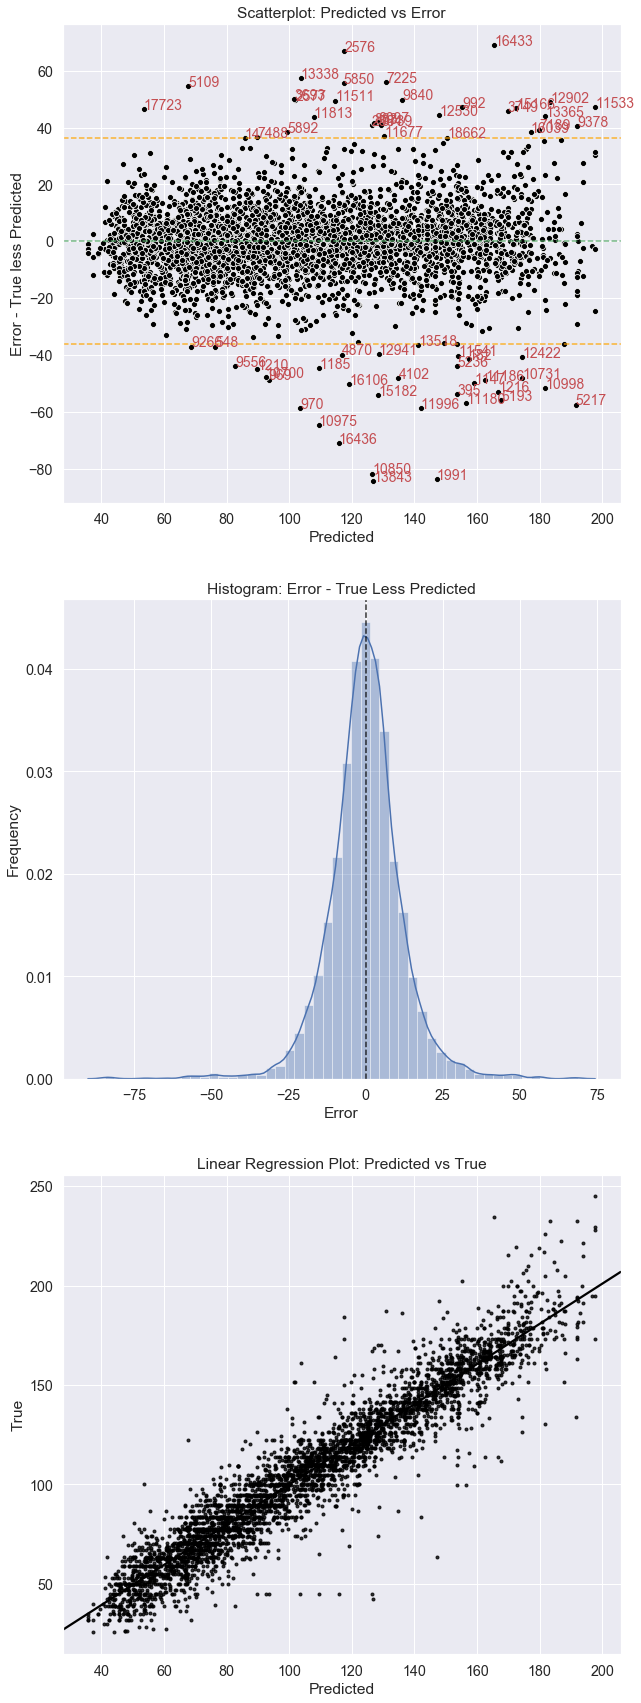

In [10]:
#LightGBM - Plot train residuals.
y_trn_pred = lgb_model.predict(trainX)
anomal = plot_residuals(predicted=y_trn_pred, true=trainY)

error count: 456 | error avg: -0.53 | high pred percent: 48.0 | low pred percent: 52.0


[10242, 17850, 17701, 10403, 15249, 17335, 2075]

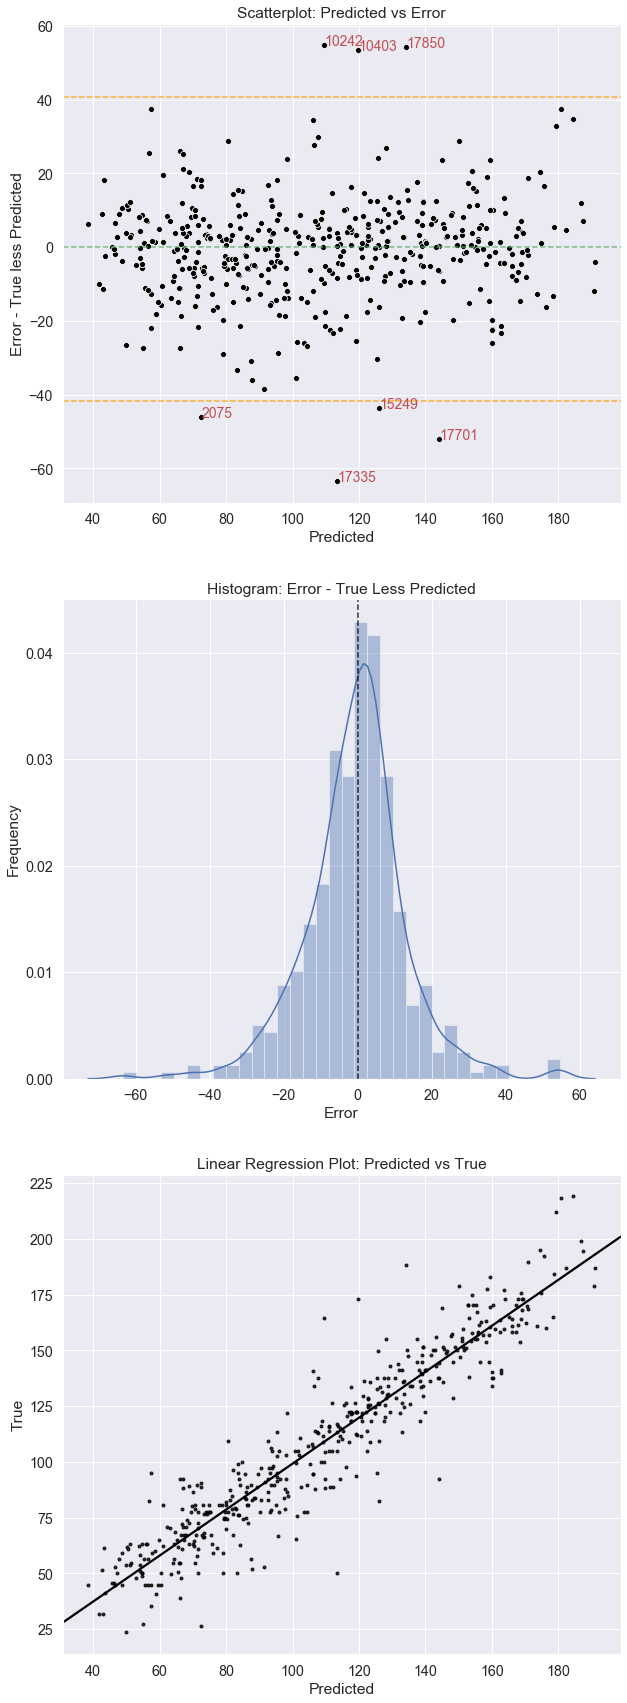

In [11]:
#LightGBM - Plot test residuals.
plot_residuals(predicted=y_test_pred, true=testY)

## Linear Regression Model

In [12]:
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
train.index.name=None; test.index.name=None; 
train.shape

(4105, 7)

In [13]:
train.head(1)

,Odometer,Seller,Price,displ,CombMPG,Year^2,Model_Trim_Year
17767,53887.0,15621.337884,38850.0,3.5,19.0,4068289.0,29460.542126


In [14]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

#Normalize Price
trainY = np.sqrt(trainY)
testY = np.sqrt(testY)

In [15]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    from sklearn.preprocessing import RobustScaler
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

#Standard scale so regression coefficient units are the same.
trainX, testX = scale_num_df(trainX.copy(), testX.copy(), trainX.columns, StandardScaler())

In [16]:
trainX.describe().round(2)

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
count,4105.00,4105.00,4105.00,4105.00,4105.00,4105.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.79,-1.32,-1.79,-1.63,-3.20,-1.54
25%,-0.80,-1.32,-0.94,-0.75,-0.70,-0.79
50%,-0.06,0.76,0.01,-0.21,0.26,-0.17
75%,0.73,0.76,0.76,0.55,0.84,0.59
max,5.03,0.76,1.80,2.96,1.62,3.98


## `Tune Linear Models with Cross Validation`

In [17]:
def train_and_valid(what_model, num_folds, X, y):
    fold_mae=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_mae.append(round(mean_absolute_error(valid_y, valid_pred), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold MAE:', fold_mae)
    avg_mae = round(np.mean(fold_mae),1)
    print('## Avg MAE:', avg_mae,'+-', round(np.std(fold_mae),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model, avg_mae

In [18]:
#Linear regression finds the coeficcients that minimize the residual sum of squares.
lr=LinearRegression(fit_intercept=True)
lr_clone, avg_mae=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold MAE: [9.52, 11.11, 10.64, 10.46, 10.87, 10.48, 9.98, 11.25, 10.24, 10.37]
## Avg MAE: 10.5 +- 0.5
## Clone R^2: 0.86


In [20]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=20).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.5046 ± 0.0159,Model_Trim_Year
0.1983 ± 0.0117,Year^2
0.0965 ± 0.0053,Odometer
0.0597 ± 0.0039,CombMPG
0.0145 ± 0.0022,Seller
0.0049 ± 0.0012,displ


## `Linear Model Predictions - Fit on 100% of train`

In [21]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution, only for coefficient
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
score_algo(linregr, testX, testY, y_pred_linregr, avg_mae)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.8648
MAE: 11.09
Ratio to Valid Score: 1.056


In [22]:
#Score original Price
score_algo(linregr, testX, testY**2, y_pred_linregr**2, avg_mae, show_ratio=False)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.8654
MAE: 2356.64


In [23]:
#Linear Regression Coefficients. Each feature has the same scale: value per unit of standard deviation.
pd.DataFrame({'feature': trainX.columns, 'coef' : np.round(linregr.coef_,2)})

,feature,coef
0,Odometer,-8.44
1,Seller,3.23
2,displ,2.12
3,CombMPG,-6.58
4,Year^2,12.45
5,Model_Trim_Year,19.89


error count: 456 | error avg: -0.47 | high pred percent: 52.2 | low pred percent: 47.8


[10242, 17850, 10403, 17335]

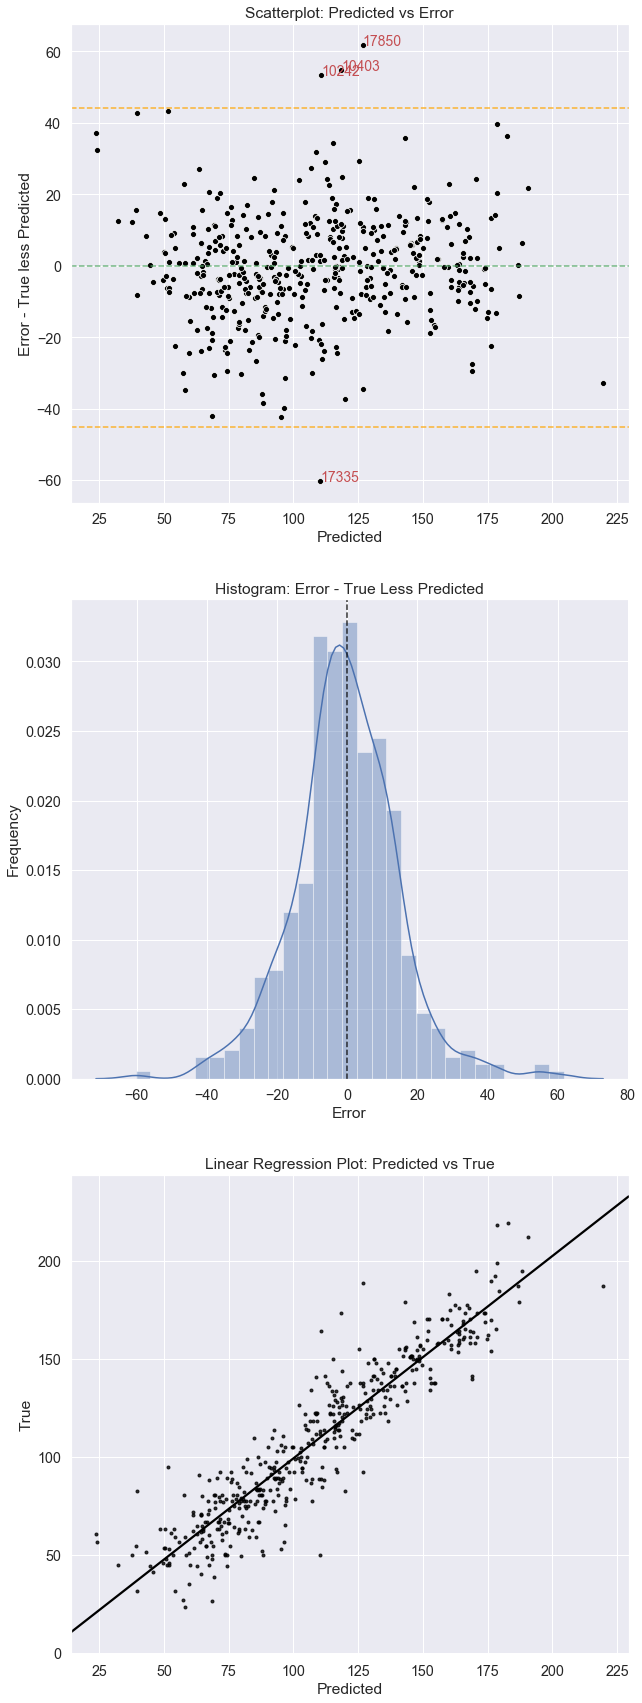

In [24]:
#Get test residuals.  A non-normal error means errors are not random.  Are there outliers?  Try transforming features
#to make them closer to normally distributed.  We will not go down this path today as we have a more accurate LightGBM
#model with better-looking residuals.  LightGBM can model non-linear relationships, in contrast to a linear regression.
plot_residuals(predicted=y_pred_linregr, true=testY)